In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
!pip install cvxpy
!pip install tqdm
!pip install empyrical

In [11]:
import cvxpy as cp
from tqdm import tqdm
import time
import empyrical as ep

In [12]:
def load_and_process_data(file_path):
    # Load the CSV file into a DataFrame with the first column as the index and parse dates
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    return df

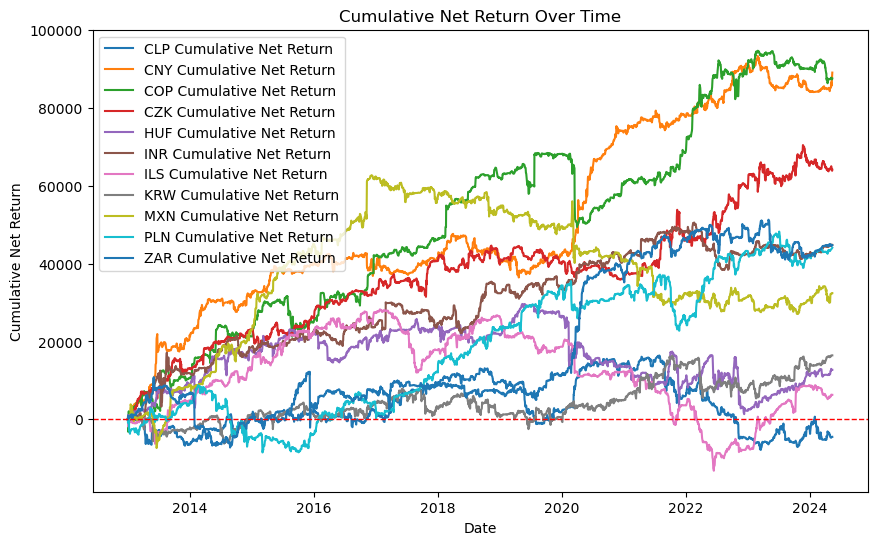

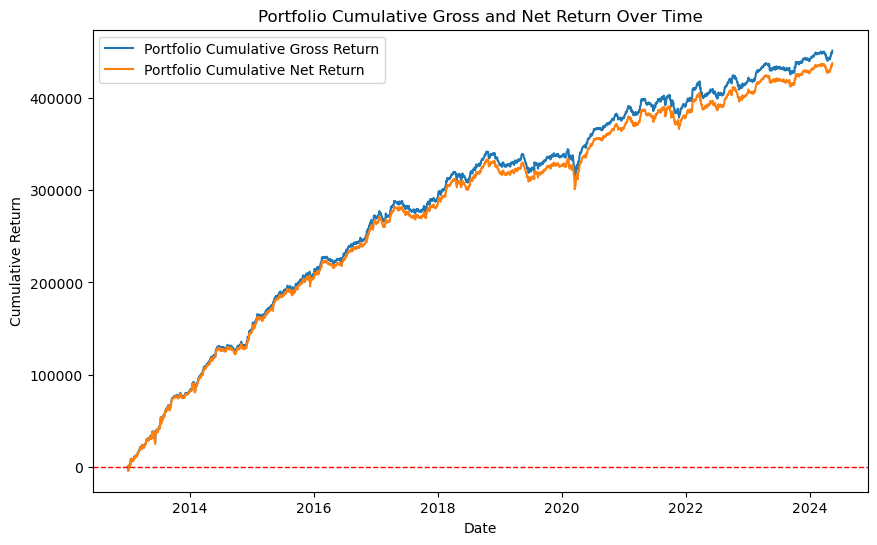

In [16]:
# Function to safely merge cumulative return into the DataFrame
def safe_merge(df, currency_df, col_name, retries=3):
    for i in range(retries):
        try:
            if col_name in df.columns:
                df.drop(columns=[col_name], inplace=True)  # Remove the column if it already exists
            df = df.merge(currency_df[[col_name]], how='left', left_index=True, right_index=True)
            return df
        except Exception as e:
            print(f"Error during merge: {e}. Retrying {i + 1}/{retries}...")
            time.sleep(1)  # Wait for 1 second before retrying
    raise Exception(f"Failed to merge after {retries} retries.")

# Load the data
file_path = '/Users/melissamertz/Documents/Bloomberg Data/CnR Momentum MVO 1dS 1mHL 3b.csv'
df = load_and_process_data(file_path)  # Ensure df is defined

# Loop through each unique currency in the DataFrame and calculate the cumulative gross and net returns
for currency in df['Currency'].unique():
    # Filter the DataFrame for the current currency
    currency_df = df[df['Currency'] == currency].copy()

    # Calculate the cumulative gross return for the current currency
    gross_col_name = f'{currency}_CUM_GROSS_RETURN'
    currency_df[gross_col_name] = currency_df['1D Gross Return'].cumsum()

    # Calculate the cumulative net return for the current currency
    net_col_name = f'{currency}_CUM_NET_RETURN'
    currency_df[net_col_name] = currency_df['1D Net Return'].cumsum()

    # Merge the cumulative gross return back into the original DataFrame
    df = safe_merge(df, currency_df, gross_col_name)

    # Merge the cumulative net return back into the original DataFrame
    df = safe_merge(df, currency_df, net_col_name)

# Create the Portfolio_CUM_GROSS_RETURN and Portfolio_CUM_NET_RETURN by summing the respective cumulative returns of all currencies
cumulative_gross_return_cols = [f'{currency}_CUM_GROSS_RETURN' for currency in df['Currency'].unique()]
cumulative_net_return_cols = [f'{currency}_CUM_NET_RETURN' for currency in df['Currency'].unique()]
df['Portfolio_CUM_GROSS_RETURN'] = df[cumulative_gross_return_cols].sum(axis=1)
df['Portfolio_CUM_NET_RETURN'] = df[cumulative_net_return_cols].sum(axis=1)

# Function to plot cumulative gross return for given currencies
def plot_cumulative_gross_returns(currencies):
    plt.figure(figsize=(10, 6))
    for currency in currencies:
        col_name = f'{currency}_CUM_GROSS_RETURN'
        try:
            plt.plot(df[df['Currency'] == currency].index, df[df['Currency'] == currency][col_name], label=f'{currency} Cumulative Gross Return')
        except KeyError as e:
            print(f"Error plotting {currency}: {e}")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Gross Return')
    plt.title(f'Cumulative Gross Return Over Time')
    plt.legend()
    plt.show()

# Function to plot cumulative net return for given currencies
def plot_cumulative_net_returns(currencies):
    plt.figure(figsize=(10, 6))
    for currency in currencies:
        col_name = f'{currency}_CUM_NET_RETURN'
        try:
            plt.plot(df[df['Currency'] == currency].index, df[df['Currency'] == currency][col_name], label=f'{currency} Cumulative Net Return')
        except KeyError as e:
            print(f"Error plotting {currency}: {e}")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Net Return')
    plt.title(f'Cumulative Net Return Over Time')
    plt.legend()
    plt.show()

# Function to plot both portfolio cumulative gross return and net return on the same chart
def plot_portfolio_cumulative_returns():
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Portfolio_CUM_GROSS_RETURN'], label='Portfolio Cumulative Gross Return')
    plt.plot(df.index, df['Portfolio_CUM_NET_RETURN'], label='Portfolio Cumulative Net Return')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Portfolio Cumulative Gross and Net Return Over Time')
    plt.legend()
    plt.show()

# Example usage: plot cumulative gross returns for selected currencies
#plot_cumulative_gross_returns(['CLP', 'CNY', 'COP', 'CZK', 'HUF', 'INR', 'ILS', 'KRW', 'MXN', 'PLN', 'ZAR'])

# Example usage: plot cumulative net returns for selected currencies
plot_cumulative_net_returns(['CLP', 'CNY', 'COP', 'CZK', 'HUF', 'INR', 'ILS', 'KRW', 'MXN', 'PLN', 'ZAR'])

# Plot both portfolio cumulative gross return and net return
plot_portfolio_cumulative_returns()

In [15]:
# Calculate the average number of non-zero "1-Day Change" entries per calendar day since 2013
# Filter the data starting from 2013
df_filtered = df[df.index >= pd.Timestamp('2013-01-01')]

# Filter out rows where "1-Day Change" is zero
df_non_zero = df_filtered[df_filtered['1-Day Change'] != 0]

# Group by date and count the number of non-zero "1-Day Change" entries for each day
daily_counts = df_non_zero.groupby(df_non_zero.index.date)['1-Day Change'].count()

# Calculate the average count per day
average_trades_per_day = daily_counts.mean()

print(f"Average number of trades per day: {average_trades_per_day:.2f}")

# Calculate the 5-day rolling returns and Sharpe Ratio for the portfolio cumulative gross return series using empyrical
# Calculate the 5-day rolling returns from the cumulative gross return series
df['Portfolio_5D_Return'] = df['Portfolio_CUM_GROSS_RETURN'].diff(5)

# Calculate the 5-day Sharpe Ratio using empyrical
sharpe_ratio_5d = ep.sharpe_ratio(df['Portfolio_5D_Return'].dropna())

print(f"5-Day Sharpe Ratio since inception for the portfolio gross return series: {sharpe_ratio_5d:.2f}")

# Calculate the average annual return since inception for the portfolio cumulative gross return series
# Calculate the annual returns from the cumulative gross return series
df_annual = df['Portfolio_CUM_GROSS_RETURN'].resample('Y').last()

# Calculate the year-over-year changes in the cumulative gross return
df_annual_return = df_annual.pct_change().dropna()

# Calculate the average annual nominal change
average_annual_nominal_change = df_annual_return.mean() * df_annual.mean()

print(f"Average annual nominal change since inception for the portfolio gross return series: {average_annual_nominal_change:.2f}")

# Calculate the maximum drawdown since inception of the cumulative gross return
def calculate_max_drawdown(series):
    peak = series.cummax()
    drawdown = peak - series
    max_drawdown = drawdown.max()
    return max_drawdown

max_drawdown = calculate_max_drawdown(df['Portfolio_CUM_GROSS_RETURN'])

print(f"Maximum drawdown since inception: {max_drawdown:.2f}")

# Calculate the maximum drawdown as a percentage of the average annual return
max_drawdown_percentage = (max_drawdown / average_annual_nominal_change) * 100

print(f"Maximum drawdown as a percentage of the average annual return: {max_drawdown_percentage:.2f}%")

def calculate_max_months_underwater(series):
    # Ensure series is sorted by date
    series = series.sort_index()

    # Calculate cumulative max to identify peaks
    peak = series.cummax()

    # Determine underwater periods
    underwater = series < peak

    # Group underwater periods
    groups = (underwater != underwater.shift()).cumsum()
    
    # Create a DataFrame to hold groups and underwater status
    df_underwater = pd.DataFrame({'series': series, 'peak': peak, 'underwater': underwater, 'group': groups})

    # Calculate the duration of each underwater period in months
    df_underwater['month'] = df_underwater.index.to_period('M')
    underwater_duration = df_underwater[df_underwater['underwater']].groupby('group')['month'].nunique()

    # Find the maximum duration
    max_months_underwater = underwater_duration.max()

    return max_months_underwater

max_months_underwater = calculate_max_months_underwater(df['Portfolio_CUM_GROSS_RETURN'])

print(f"Maximum number of months underwater: {max_months_underwater}")

Average number of trades per day: 5.72
5-Day Sharpe Ratio since inception for the portfolio gross return series: 1.34
Average annual nominal change since inception for the portfolio gross return series: 57736.94
Maximum drawdown since inception: 32852.04
Maximum drawdown as a percentage of the average annual return: 56.90%
Maximum number of months underwater: 17
